## Introduction

In this guided project I shall use a K-nearest neighbours (from the scikitlearn library) method to predict car prices. 

The data is from the UCI ML repo (https://archive.ics.uci.edu/ml/datasets/automobile). 

In [1]:
#Load the necessary packages
import pandas as pd
import numpy as np
from sklearn.neighbors import KNeighborsRegressor as KNR # This will be the method
from sklearn.metrics import mean_squared_error as MSE #this will be the metric
import matplotlib.pyplot as plt
# I think this is all I need for now... Load the data
cols = ['symboling', 'normalized_losses', 'make', 'fuel_type', 'aspiration', 'num_of_doors', 'body_style', 
        'drive_wheels', 'engine_location', 'wheel_base', 'length', 'width', 'height', 'curb_weight', 'engine_type', 
        'num_of_cylinders', 'engine_size', 'fuel_system', 'bore', 'stroke', 'compression_rate', 'horsepower', 'peak_rpm', 'city_mpg', 'highway_mpg', 'price']
#This is needed as the original file does not contain the names (from the documentation)
cars=pd.read_csv("imports-85.data", names=cols)
from sklearn.preprocessing import MinMaxScaler as scaler
from sklearn.model_selection import train_test_split
%matplotlib inline

In [2]:
cars.head()

,symboling,normalized_losses,make,fuel_type,aspiration,num_of_doors,body_style,drive_wheels,engine_location,wheel_base,...,engine_size,fuel_system,bore,stroke,compression_rate,horsepower,peak_rpm,city_mpg,highway_mpg,price
0,3,?,alfa-romero,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,13495
1,3,?,alfa-romero,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,16500
2,1,?,alfa-romero,gas,std,two,hatchback,rwd,front,94.5,...,152,mpfi,2.68,3.47,9.0,154,5000,19,26,16500
3,2,164,audi,gas,std,four,sedan,fwd,front,99.8,...,109,mpfi,3.19,3.40,10.0,102,5500,24,30,13950
4,2,164,audi,gas,std,four,sedan,4wd,front,99.4,...,136,mpfi,3.19,3.40,8.0,115,5500,18,22,17450


## Exploration, feature selection: Exploration
Price is the target column. From among the other columns I shall choose the ones that might be the best to use for something like this.

In [3]:
cars.describe()

,symboling,wheel_base,length,width,height,curb_weight,engine_size,compression_rate,city_mpg,highway_mpg
count,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000
mean,0.834146,98.756585,174.049268,65.907805,53.724878,2555.565854,126.907317,10.142537,25.219512,30.751220
std,1.245307,6.021776,12.337289,2.145204,2.443522,520.680204,41.642693,3.972040,6.542142,6.886443
min,-2.000000,86.600000,141.100000,60.300000,47.800000,1488.000000,61.000000,7.000000,13.000000,16.000000
25%,0.000000,94.500000,166.300000,64.100000,52.000000,2145.000000,97.000000,8.600000,19.000000,25.000000
50%,1.000000,97.000000,173.200000,65.500000,54.100000,2414.000000,120.000000,9.000000,24.000000,30.000000
75%,2.000000,102.400000,183.100000,66.900000,55.500000,2935.000000,141.000000,9.400000,30.000000,34.000000
max,3.000000,120.900000,208.100000,72.300000,59.800000,4066.000000,326.000000,23.000000,49.000000,54.000000


The price is not represented as a numeric value, the reason behind this is that there are 4 cars in the dataset with missing prices ("?" string in the price column). I shall remove them to convert the price to integers.

In [4]:
cars=cars[~(cars.price=="?")]
cars.price=cars.price.astype(int)


## Exploration, feature selection: Numericals

For now I shall only use numeric values (though 'brand' might has to do something with the price). I have an easy task in choosing these as the documentation does mention all.

In [5]:
numeric_cols=['normalized_losses', 'wheel_base', 'length', 'width', 'height', 'curb_weight', 'engine_size', 'bore', 'stroke', 'compression_rate', 'horsepower', 'peak_rpm', 'city_mpg', 'highway_mpg', 'price']
cars=cars[numeric_cols]

In [6]:
cars.replace("?", np.nan, inplace=True)
for col in numeric_cols:
    cars[col]=cars[col].astype(float)

These pesky question marks are present in the other columns as well, but as they are not the "target" column, I can leave them as nan-s

In [7]:
cars.describe()

,normalized_losses,wheel_base,length,width,height,curb_weight,engine_size,bore,stroke,compression_rate,horsepower,peak_rpm,city_mpg,highway_mpg,price
count,164.000000,201.000000,201.000000,201.000000,201.000000,201.000000,201.000000,197.000000,197.000000,201.000000,199.000000,199.000000,201.000000,201.000000,201.000000
mean,122.000000,98.797015,174.200995,65.889055,53.766667,2555.666667,126.875622,3.330711,3.256904,10.164279,103.396985,5117.587940,25.179104,30.686567,13207.129353
std,35.442168,6.066366,12.322175,2.101471,2.447822,517.296727,41.546834,0.270793,0.319256,4.004965,37.553843,480.521824,6.423220,6.815150,7947.066342
min,65.000000,86.600000,141.100000,60.300000,47.800000,1488.000000,61.000000,2.540000,2.070000,7.000000,48.000000,4150.000000,13.000000,16.000000,5118.000000
25%,94.000000,94.500000,166.800000,64.100000,52.000000,2169.000000,98.000000,3.150000,3.110000,8.600000,70.000000,4800.000000,19.000000,25.000000,7775.000000
50%,115.000000,97.000000,173.200000,65.500000,54.100000,2414.000000,120.000000,3.310000,3.290000,9.000000,95.000000,5200.000000,24.000000,30.000000,10295.000000
75%,150.000000,102.400000,183.500000,66.600000,55.500000,2926.000000,141.000000,3.590000,3.410000,9.400000,116.000000,5500.000000,30.000000,34.000000,16500.000000
max,256.000000,120.900000,208.100000,72.000000,59.800000,4066.000000,326.000000,3.940000,4.170000,23.000000,262.000000,6600.000000,49.000000,54.000000,45400.000000


At first let's look at the normalized_losses column:
 - It has a huge amount of missing values, so I would rather not drop the rows. I can either replace the missing values with something, or drop the column.

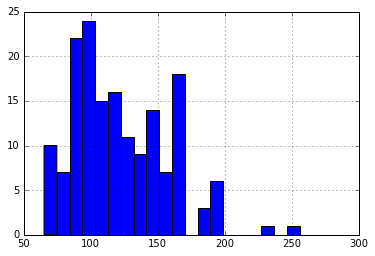

In [8]:
cars.normalized_losses.hist(bins=20)

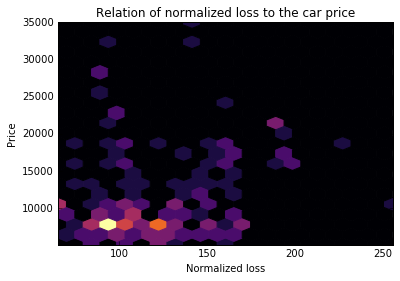

In [9]:
fig, ax=plt.subplots()
ax.hexbin(cars.normalized_losses, cars.price, gridsize=20, cmap="inferno")
plt.title("Relation of normalized loss to the car price")
ax.set_xlabel("Normalized loss")
ax.set_ylabel("Price")

This is the best way to see (this, or the scatter plot but a scatter plot did not show anything either), and I can't determine a strong correlation between the price and the normalized loss. There might be a weak correlation, but that can be an effect of the low sample size around 200 n_loss.

With this in mind, I think there is no significant loss in just excluding this column.

In [10]:
cars.drop("normalized_losses", inplace=True, axis=1)

In [11]:
cars.isnull().sum()

wheel_base          0
length              0
width               0
height              0
curb_weight         0
engine_size         0
bore                4
stroke              4
compression_rate    0
horsepower          2
peak_rpm            2
city_mpg            0
highway_mpg         0
price               0
dtype: int64

In the remaining cases I think I can just substitute the low number of missing data with the mean values.

In [12]:
for col in cars.columns:
    cars.loc[cars[col].isnull(), col]=cars[col].mean()

In [13]:
cars.describe()

,wheel_base,length,width,height,curb_weight,engine_size,bore,stroke,compression_rate,horsepower,peak_rpm,city_mpg,highway_mpg,price
count,201.000000,201.000000,201.000000,201.000000,201.000000,201.000000,201.000000,201.000000,201.000000,201.000000,201.000000,201.000000,201.000000,201.000000
mean,98.797015,174.200995,65.889055,53.766667,2555.666667,126.875622,3.330711,3.256904,10.164279,103.396985,5117.587940,25.179104,30.686567,13207.129353
std,6.066366,12.322175,2.101471,2.447822,517.296727,41.546834,0.268072,0.316048,4.004965,37.365602,478.113178,6.423220,6.815150,7947.066342
min,86.600000,141.100000,60.300000,47.800000,1488.000000,61.000000,2.540000,2.070000,7.000000,48.000000,4150.000000,13.000000,16.000000,5118.000000
25%,94.500000,166.800000,64.100000,52.000000,2169.000000,98.000000,3.150000,3.110000,8.600000,70.000000,4800.000000,19.000000,25.000000,7775.000000
50%,97.000000,173.200000,65.500000,54.100000,2414.000000,120.000000,3.310000,3.290000,9.000000,95.000000,5117.587940,24.000000,30.000000,10295.000000
75%,102.400000,183.500000,66.600000,55.500000,2926.000000,141.000000,3.580000,3.410000,9.400000,116.000000,5500.000000,30.000000,34.000000,16500.000000
max,120.900000,208.100000,72.000000,59.800000,4066.000000,326.000000,3.940000,4.170000,23.000000,262.000000,6600.000000,49.000000,54.000000,45400.000000


## Feature selection: Normalization

This is reasonably clean. 
I think I can now just normalize everything to be between 0 and 1.

I shall achieve this with sklearn's minmaxscaler rather than "manually"

In [14]:
my_scaler=scaler(feature_range=(0,1))
for col in cars.columns[:-1]:#the last column is the price, I don't want that to be normed.
    cars[col]=my_scaler.fit_transform(cars[col].values.reshape((-1,1)))
cars.head()

,wheel_base,length,width,height,curb_weight,engine_size,bore,stroke,compression_rate,horsepower,peak_rpm,city_mpg,highway_mpg,price
0,0.058309,0.413433,0.324786,0.083333,0.411171,0.260377,0.664286,0.290476,0.1250,0.294393,0.346939,0.222222,0.289474,13495.0
1,0.058309,0.413433,0.324786,0.083333,0.411171,0.260377,0.664286,0.290476,0.1250,0.294393,0.346939,0.222222,0.289474,16500.0
2,0.230321,0.449254,0.444444,0.383333,0.517843,0.343396,0.100000,0.666667,0.1250,0.495327,0.346939,0.166667,0.263158,16500.0
3,0.384840,0.529851,0.504274,0.541667,0.329325,0.181132,0.464286,0.633333,0.1875,0.252336,0.551020,0.305556,0.368421,13950.0
4,0.373178,0.529851,0.521368,0.541667,0.518231,0.283019,0.464286,0.633333,0.0625,0.313084,0.551020,0.138889,0.157895,17450.0


In [15]:
cars.describe()

,wheel_base,length,width,height,curb_weight,engine_size,bore,stroke,compression_rate,horsepower,peak_rpm,city_mpg,highway_mpg,price
count,201.000000,201.000000,201.000000,201.000000,201.000000,201.000000,201.000000,201.000000,201.000000,201.000000,201.000000,201.000000,201.000000,201.000000
mean,0.355598,0.494045,0.477697,0.497222,0.414145,0.248587,0.564793,0.565192,0.197767,0.258864,0.394934,0.338308,0.386489,13207.129353
std,0.176862,0.183913,0.179613,0.203985,0.200658,0.156781,0.191480,0.150499,0.250310,0.174606,0.195148,0.178423,0.179346,7947.066342
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5118.000000
25%,0.230321,0.383582,0.324786,0.350000,0.264158,0.139623,0.435714,0.495238,0.100000,0.102804,0.265306,0.166667,0.236842,7775.000000
50%,0.303207,0.479104,0.444444,0.525000,0.359193,0.222642,0.550000,0.580952,0.125000,0.219626,0.394934,0.305556,0.368421,10295.000000
75%,0.460641,0.632836,0.538462,0.641667,0.557797,0.301887,0.742857,0.638095,0.150000,0.317757,0.551020,0.472222,0.473684,16500.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,45400.000000


All the values are beautifully between 0 and 1.

To find the most relevant features, I will build an univariate model for every column that is still "in the game", and predict with them. 

That should give a general feeling of which features have a bigger influence over the price. Also, that is the simplest model I can imagine - progressing towards more difficult ones is generally a good idea.

## Univariate predictions

After a few runs I can see that the bottom scores can change around a LOT depending on the random state. 

This is not ideal, and I think calls for a fixed random state - or more like, 10. So basically I will run the whole fitting for every feature 10 times, and the dictionaries will have 10 values this way. That might be a better indicator of which are the best features to go by.

In [16]:
def km_train_test(train_col, target_col="price", dfobj=cars, rstate=0, kval=5):#This function is a single process
    #Split the data into training and test set.
    X_train, X_test, y_train, y_test = train_test_split(dfobj[train_col].values.reshape((-1,1)), dfobj[target_col].values.reshape((-1,1)), random_state=rstate)
    #initiate regressor, fit and predict
    #I did not use the test_size parameter as the default .25 should be good
    my_knr=KNR(n_neighbors=kval) #Everything as default since I'm currently not finetuning, just feature-selecing.
    my_knr.fit(X_train, y_train)#fit
    pred_prices=my_knr.predict(X_test)#predict
    mse = MSE(y_test, pred_prices)#mean squared error
    return np.sqrt(mse)#return the root of the MSE



In [17]:
accuracy_vals={}
for col in cars.columns[:-1]:
    accuracy_vals[col]=[km_train_test(col)]#Initiate a list here
    for state in range(1,10):#0 is already used
        accuracy_vals[col].append(km_train_test(col, rstate=state))#I only need to input the train_col value
    
accuracy_vals=pd.DataFrame(accuracy_vals)
accuracy_vals.describe()

,bore,city_mpg,compression_rate,curb_weight,engine_size,height,highway_mpg,horsepower,length,peak_rpm,stroke,wheel_base,width
count,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000
mean,6854.743226,4451.834806,6336.139125,4192.025401,3418.171326,8081.546658,4222.414721,3971.805910,5481.106928,7725.510037,7518.873916,6067.602229,4326.995518
std,659.668176,493.198448,564.100472,819.631583,314.722331,921.503431,785.435604,621.134778,886.737586,645.939249,739.196448,832.639115,889.826979
min,5753.243152,3514.051144,5491.600612,2974.516034,3068.471405,6947.385535,2791.517558,2962.868822,3985.420333,6936.420072,6231.803414,4749.463611,3077.076513
25%,6600.755999,4232.092205,5894.895846,3739.933731,3191.983521,7485.741446,3870.641185,3483.943679,4837.298545,7170.618094,7232.910735,5559.645200,3750.379487
50%,6831.558032,4415.542034,6373.655485,4076.461974,3343.235704,7794.117057,4142.251550,3982.489968,5408.389370,7778.199948,7657.866913,6263.799141,3956.647560
75%,7171.976195,4700.112810,6587.510484,4729.759569,3561.201888,8861.059997,4551.779460,4473.370312,6224.060910,8000.196816,7767.415498,6512.280895,5242.722918
max,7783.016811,5366.467019,7180.785815,5524.700238,4075.070396,9687.880004,5629.623138,4810.806122,6621.848824,8869.243969,8570.753663,7245.642225,5540.692092


In [18]:
accuracy_vals.describe().sort_values(by="mean", axis=1)

,engine_size,horsepower,curb_weight,highway_mpg,width,city_mpg,length,wheel_base,compression_rate,bore,stroke,peak_rpm,height
count,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000
mean,3418.171326,3971.805910,4192.025401,4222.414721,4326.995518,4451.834806,5481.106928,6067.602229,6336.139125,6854.743226,7518.873916,7725.510037,8081.546658
std,314.722331,621.134778,819.631583,785.435604,889.826979,493.198448,886.737586,832.639115,564.100472,659.668176,739.196448,645.939249,921.503431
min,3068.471405,2962.868822,2974.516034,2791.517558,3077.076513,3514.051144,3985.420333,4749.463611,5491.600612,5753.243152,6231.803414,6936.420072,6947.385535
25%,3191.983521,3483.943679,3739.933731,3870.641185,3750.379487,4232.092205,4837.298545,5559.645200,5894.895846,6600.755999,7232.910735,7170.618094,7485.741446
50%,3343.235704,3982.489968,4076.461974,4142.251550,3956.647560,4415.542034,5408.389370,6263.799141,6373.655485,6831.558032,7657.866913,7778.199948,7794.117057
75%,3561.201888,4473.370312,4729.759569,4551.779460,5242.722918,4700.112810,6224.060910,6512.280895,6587.510484,7171.976195,7767.415498,8000.196816,8861.059997
max,4075.070396,4810.806122,5524.700238,5629.623138,5540.692092,5366.467019,6621.848824,7245.642225,7180.785815,7783.016811,8570.753663,8869.243969,9687.880004


So now I can be more or less confident that this is the "order" in which the features weigh in.

In [19]:
order=accuracy_vals.describe().sort_values(by="mean", axis=1).columns
order

Index(['engine_size', 'horsepower', 'curb_weight', 'highway_mpg', 'width',
       'city_mpg', 'length', 'wheel_base', 'compression_rate', 'bore',
       'stroke', 'peak_rpm', 'height'],
      dtype='object')

As next, I do the same but change the k-values as well - still on the univariate models. I will once again run through with the 10 random states and plot the mean (and the std) to see how the rmse evolves.

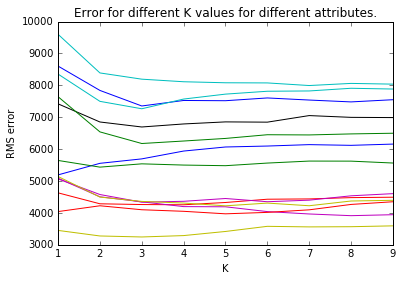

In [39]:
fig, ax=plt.subplots()
best_uni=10000
for col in cars.columns[:-1]:
    accuracy_for_k={}
    mean=[]
    for kval in range(1,10):
        accuracy_for_k[kval]=[km_train_test(col, kval=kval)]#Initiate a list here
        for state in range(1,10):#0 is already used
            accuracy_for_k[kval].append(km_train_test(col, rstate=state, kval=kval))#I only need to input the train_col value
    #Now I have a dict for differentK values, sum them for plotting 
        mean.append(np.mean(accuracy_for_k[kval]))
        if mean[-1]<best_uni:
            best_uni=mean[-1]
    ax.plot(range(1,10),mean, "-", label=col )
    ax.set_xlabel("K")
    ax.set_ylabel("RMS error")
ax.set_title("Error for different K values for different attributes.")

It seems that for most of the columns there isn't much change after K=3 in the accuracy, so that might be a good starting point for the multivariate prediction.

Fortunately, the "optimal" K values don't change the errors of their respective columns too drastically, so if I won't adjust the _order_ variable, I don't make a huge mistake.

## Multivariate predictions

In [29]:
def km_train_test_mv(train_cols, target_col="price", dfobj=cars, rstate=0, kval=5):#This function is a single process - multivariate
    #Split the data into training and test set.
    X_train, X_test, y_train, y_test = train_test_split(dfobj[train_cols], dfobj[target_col].values.reshape((-1,1)), random_state=rstate)#The first reshape is no longer needed as now var>1
    #initiate regressor, fit and predict
    #I did not use the test_size parameter as the default .25 should be good
    my_knr=KNR(n_neighbors=kval) #Everything as default since I'm currently not finetuning, just feature-selecing.
    my_knr.fit(X_train, y_train)#fit
    pred_prices=my_knr.predict(X_test)#predict
    mse = MSE(y_test, pred_prices)#mean squared error
    return np.sqrt(mse)#return the root of the MSE



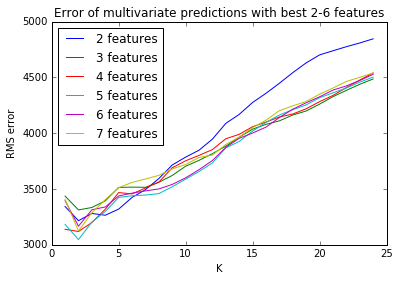

In [40]:
fig, ax=plt.subplots()
best_multi=10000
for features in range(2,8):
    accuracy_for_k={}
    mean=[]
    for kval in range(1,25):
        accuracy_for_k[kval]=[km_train_test(col, kval=kval)]#Initiate a list here
        for state in range(1,10):#0 is already used
            accuracy_for_k[kval].append(km_train_test_mv(order[:features], rstate=state, kval=kval))#I only need to input the train_col value
    #Now I have a dict for differentK values, sum them for plotting 
        mean.append(np.mean(accuracy_for_k[kval]))
        if mean[-1]<best_multi:
            best_multi=mean[-1]
    ax.plot(range(1,25),mean, "-", label=str(features)+" features" )
    ax.set_xlabel("K")
    ax.set_ylabel("RMS error")

ax.set_title("Error of multivariate predictions with best 2-6 features")
ax.legend(loc="upper left")


## Discussion

So... this is kind of surprising, but using the top 5 features ('engine_size', 'horsepower', 'curb_weight', 'highway_mpg', 'width') brought the overall best solution with k=2, and it was very close to the best univariate prediction (best_uni=3246, best_multi=3047). This RMSE is in my opinion too high - I would not trust something with an error this high -, but considering the circumstances (The sample size is 201 cars in total, and we have only used the numeric features), it is not terrible.

Honestly I did not expect e.g. 'width' to play a role here, but it seems that is part of the 'best 5'. 
As a next step one could rearrange the order among them since as it seems there are a bunch of features with almost identical errors - some other combination may achieve a slightly better fit.

 

## Paths to improvement
There are a few clear ways to improve the predictions in this project: 

    - Using (some of) the non-numeric columns could probably increase the accuracy - as we all know, cars from different brands tend to be in very different price ranges. One way to do so is to swap out the name of each brand to the average price tag of said brand, and use it as a numeric value.
    - Of course the train-test split is still something that could be - especially with such small sample - swapped out to cross-validation.
    - Trying more combinations of the numeric parameters could also result in an